<a href="https://colab.research.google.com/github/mudogruer/transformers/blob/main/course/en/chapter3/fine-tuning/sentiment-analysis-with-6-emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!pip install transformers[torch]

In [28]:
from datasets import load_dataset
import datasets
from datasets.tasks import TextClassification

raw_datasets = load_dataset("dair-ai/emotion")
raw_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [11]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[88]

{'text': 'i feel so worthless during those times i was struggling finding work',
 'label': 0}

In [12]:
raw_train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [14]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("dair-ai/emotion")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [16]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [18]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 32]),
 'token_type_ids': torch.Size([8, 32]),
 'attention_mask': torch.Size([8, 32])}

In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.6682, grad_fn=<NllLossBackward0>) torch.Size([8, 6])


In [21]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

10000


In [24]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [25]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.2 MB/s eta 0:00:00


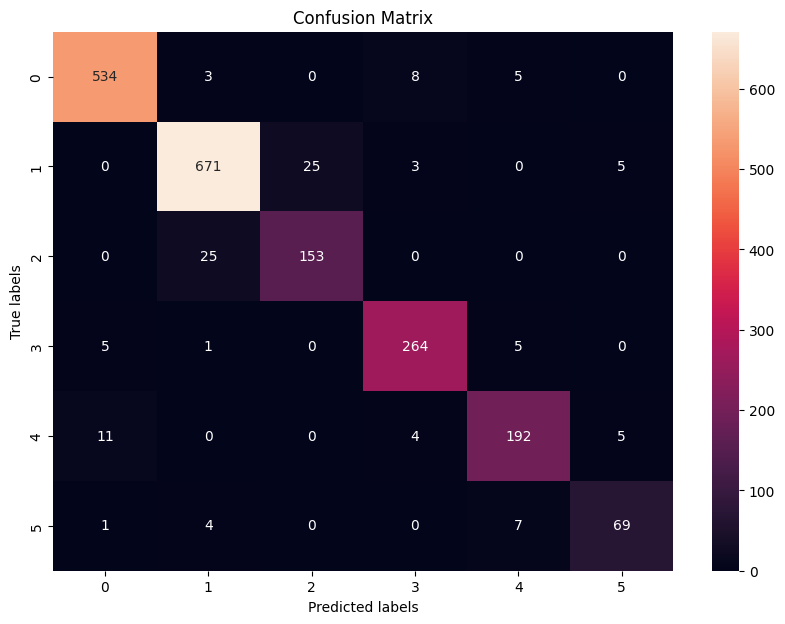

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97       550
     Class 1       0.95      0.95      0.95       704
     Class 2       0.86      0.86      0.86       178
     Class 3       0.95      0.96      0.95       275
     Class 4       0.92      0.91      0.91       212
     Class 5       0.87      0.85      0.86        81

    accuracy                           0.94      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.94      0.94      0.94      2000



In [71]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your model, eval_dataloader, and device are already set up
model.eval()

all_preds = []
all_labels = []

# Evaluate the model
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(6)], columns=[i for i in range(6)])

# Calculate classification report
report = classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(6)])

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='g')  # 'g' format avoids scientific notation
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:\n", report)


In [72]:
def predict(sentence):
    # Tokenize and encode the sentence
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    # Get prediction probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs

In [43]:
predictions

tensor([5, 4, 3, 0, 1, 1, 1, 1], device='cuda:0')

In [86]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification


def predict_single_sentence(sentence):
    # Tokenize and encode the sentence for BERT
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        padding=True,
        return_attention_mask=True,
        return_tensors='pt',     # PyTorch tensors
    )

    # Move tensors to the configured device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # No gradient needed
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(input_ids, attention_mask=attention_mask)

    # Move logits to CPU and convert to numpy
    logits = outputs[0].detach().cpu().numpy()
    # Convert logits to probabilities (softmax)
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

    # Return the probabilities
    return probabilities

# Example usage
sentence = """That shit my month"""
probabilities = predict_single_sentence(sentence)
#sadness', 'joy', 'love', 'anger', 'fear', 'surprise'
print("sadness: " , probabilities[0][0])
print("joy: " , probabilities[0][1])
print("love: " , probabilities[0][2])
print("anger: " , probabilities[0][3])
print("fear: " , probabilities[0][4])
print("suprise: " , probabilities[0][5])

sadness:  0.41551954
joy:  0.023837332
love:  0.00063316873
anger:  0.55815834
fear:  0.0013188632
suprise:  0.0005327998
